INTRODUCTION

Convolutional Neural Networks (CNN) have become standard for any computer vision task due to their ability to extract features from spatial information within images.  A process known as covolution uses kernels/filters to boil down images to much more meaningful pieces of information known as feature maps.  Max pooling usually follows convolutions in order to downsize the feature maps into a something much more computationably reasonable.  This is allowed as most vision tasks can afford some information loss and the number of trainable parameters is drastically reduced.

The most basic example of a vision task is a binary classifier.  A picture of a cat or a dog is presented to the neural network and it outputs a 1 if the photo is of a dog and 0 if it is a cat.  This can be expanded to multiple classes where there are n outputs for n number of classes and each output represents the 'probability' that the input is a photo of the corresponding class.  The biggest roadblock with these forms of classification is that the CNN has no idea how to handle images of objects that it was not trained on.  If a dog/cat classifier was given a picture of a bear cub, it would still predict either cat or dog.  Or if there were no chihuahuas in the training set, there's a possibility of it being classified as a cat.  This may sound trivial, but in a paper with a CNN trained on a wide range of classes, the neural net decided that the most indicative feature of fish were fingertips.  As it turns out, most photos of fish in the dataset were trophy pictures, where the fishermen were holding the fish up to the camera.  Essentially, it is very important to keep in mind what is missing from the dataset as well as what the dataset itself contains, and that high performance by the model is not guaranteed to translate to the real world.

The introduction of the autoencoder enabled much more complex computer vision tasks to be done.  An autoencoder is just like a convolutional neural network, except for it 'decodes' the final set of feature maps, trying to reconstruct the image, instead of using fully connected layers to boil down the feature maps further into the desired output.  One of these new tasks is known as image segmentation.  Image Segmentation is the process of determining which parts of an image represent each class.  
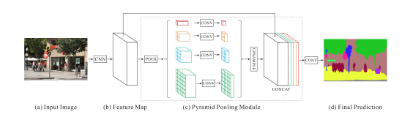
The input is an image, and the output is a color coded version of the image where each color represents each class (the actual output of the neural network is not a color image depicted by the figure but that's what it represents).  The approach is similiar to that of traditional classification networks except for the classification happens at the pixel level (and the loss is usually L1 instead of cross entropy).

The challenge for fellowship.ai is to perform a subset of image segmentation known as portrait segmentation (image matting).  More specifically, on a dataset of celebrities.  Portrait segmentation is the process of extracting a self-portrait (or picture of a person) from the background.  The two main components of this computer vision task is that the two classes are foreground and background, and the main point of interest is a person (normally above the shoulder).

There are two big challenges associated with portrait segmentation.  Portrait segmentation is very detail oriented when compared to other forms of segmentation.  Green screen is reliable but even that can look off or blurry around edges.  Hair is very fine and requires precision to crop out, all the while being very noticeable when it's done incorrectly.  Additionally, it's a very difficult task to cut out backgrounds with varying colors or similar colors to the foreground.  This is why green screen is normally used, and other statistical methods fail with a confusing background.  I will be evaluating my models on how well they handle hair as well as unique backgrounds.

DATASET

The first thing I noticed is that there are distortions in a non-negligle amount of the images in this dataset.  The top of the image is stretched out upwards, distorting the size of the head

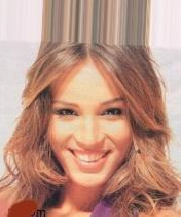

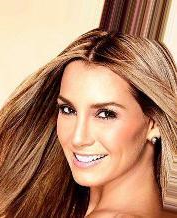

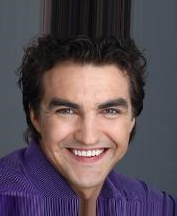

Luckily, this dataset does not have any ground truth segmentations so that I will not be training on this, only testing my model with these images.  I'm curious to see how the model I train will treat these distortions, whether it will have learned the shape of the head or if the model will interpret them as hats.  However, it is not fair to use these images as a baseline for the final analysis.


Overall, this dataset looks fairly straight forward.  Every image contains the portrait (shoulders up) of a celebrity where the face takes up the majority of the photo.  This means that there is a clear pattern that the neural network will be able to pick up and should be able to adjust to hats and hair much more easily than if the images were of an entire body, multiple people, or included other animals.  While most photos have clean backgrounds that make this vision task easy, I've included below several examples where the background can possibly throw off the modle.

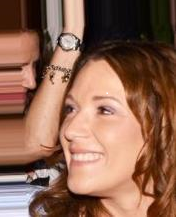

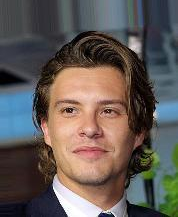

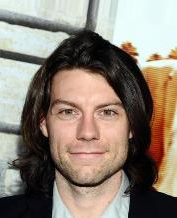

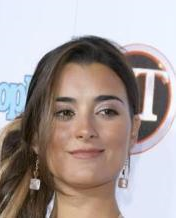

And finally, here are some examples of hats that may throw off the model and will be interesting to look into.

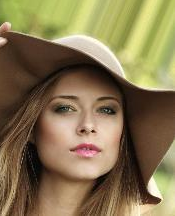

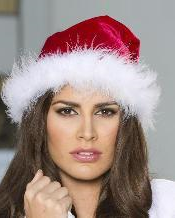

DATASET EXPLORATION

As discussed in the introduction, the dataset is paramount to any deep learning project.  Creating pixel perfect alpha mattes (segmented image into 1s (foreground) and 0s (background) of original image) is time consuming, especially on a big scale.  Therefore, it is not feasible for me to construct my own dataset from scratch.  Initially, I wanted to solve a potential issue with the celebrity dataset.  There is only one person in each photo, which is a glaring issue for any practical use going forwards.  My plan was to train on the Deep Image Matting dataset.  It contains pictures of people as well as mattes containing numbers 0-18, where 0 is the background and the other numbers refer to things like 'left shoe' and 'face'.

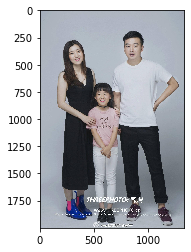

In [15]:
# importing necessary libraries and choosing a sample image from the dataset
import os
from os import path
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt


FOLDER = '/LV-MHP-v1/'
CURRENT_DIR = path.abspath(path.curdir)
files = os.listdir(CURRENT_DIR + FOLDER + 'images')

sample = random.choice(files)
image = cv2.imread(CURRENT_DIR + FOLDER + '/images/' + sample)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

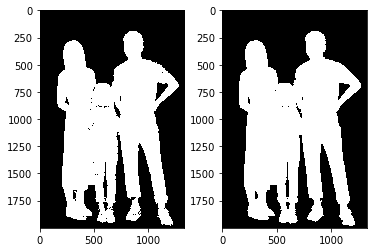

In [40]:
# Each person has their own alpha matte image. On top of turning all nonzero mattes to 0, I need to add up each individual 
# alpha matte together to get the complete alpha matte
# the second image is a smoothened version where the gaps are removed

mattelist = [file for file in os.listdir(CURRENT_DIR + FOLDER + '/annotations/') if sample.split('.')[0] in file]

for person in mattelist:
    
    image = cv2.imread(CURRENT_DIR + FOLDER + '/annotations/' + person)
    
    try:
        matte = np.where(matte + image > 0, float(1),0)
    except:
        matte = np.where(image>0,float(1),0)

        
f, axarr = plt.subplots(1,2)   
kernel = np.ones((5,5), np.uint8)     
axarr[0].imshow(matte)
axarr[1].imshow(cv2.dilate(matte, kernel, iterations=1))

There are a few glaring issues with this.  Firstly, there are gaps in the mattes.  This happens in almost every image.  Additionally, the photos have images of people that are too far away so it is impossible to get good resolution.  I can smooth the image to remove the gaps, but this will make the definition even worse.  Therefore, I've decided to scrap the idea of working with multiple people.  I believe that the detail oriented approach is much more desirable than a low-res variation that can arbitrarily handle multiple people.  I will, however, test my model on a picture with multiple people as well as photos of a full body just to see how it handles these fringe cases.

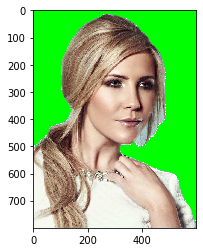

In [9]:
# Evaluating the quality of the alpha mattes inside the SegmentAI dataset found in kaggle

FILE = '/Sample_Image.png'

sample = cv2.cvtColor(cv2.imread(CURRENT_DIR + FILE), cv2.COLOR_BGR2RGB)
sample[np.where((sample==[0,0,0]).all(axis=2))] = [0,255,0]
plt.imshow(sample)

I was looking forward to using this dataset as there were many images and the portrait style images matched up a lot closer to the challenge.  Unfortunately, a cursory look through some sample alpha mattes and I saw some sketchy croppings so I decided to pull up a sample image where the hair looked ok (and where the hair was clearly in a position that it should show strands).  When displaying a green background, it becomes very clear that not only the matting does not consider the space in between the strands of hair as part of the background but the matting around the person as a whole is not high quality.

My next target was the PFCN dataset.  This looks very promising based on the sample image that they use in their website (http://xiaoyongshen.me/webpage_portrait/index.html)

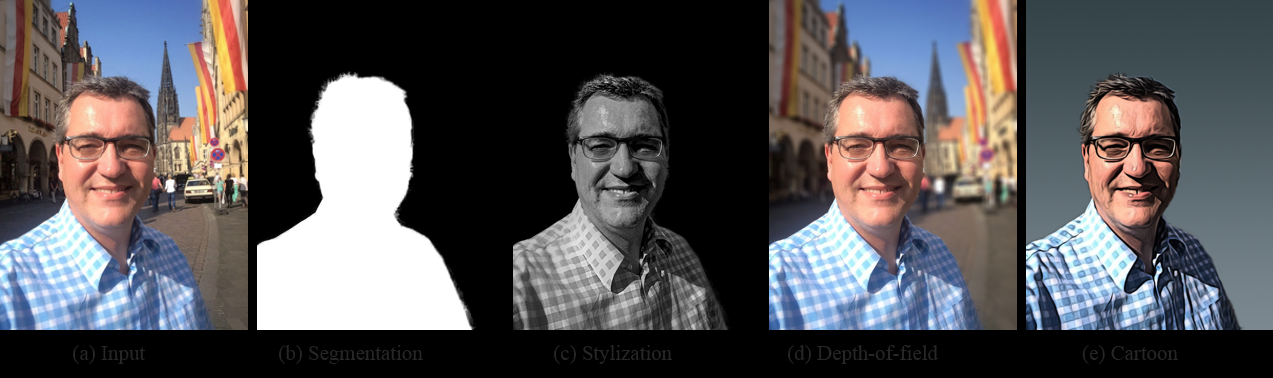

This image seems to have detailed alpha mattes that include well mapped hair.

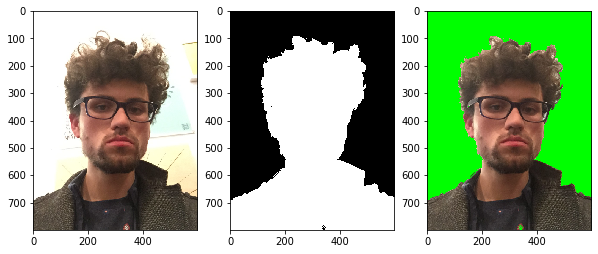

In [42]:
# EG1800 dataset
# the mattes are stored in an access database and the images are stored in separate URLs
# I'll explain this more in the next notebook where I go over the data processing

import os
from os import path
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.io import loadmat
from skimage import io

CURRENT_DIR = path.abspath(path.curdir)
URL =  "http://farm6.static.flickr.com/5607/15613214137_efb50538b5_b.jpg"
image = io.imread(URL)
crop = [0,1023,0,767]
image = image[crop[0]:crop[1],crop[2]:crop[3],:]
image = cv2.resize(image,(600,800))

new_mask = '/[EG_code_data]_release/data/images_mask/00570_mask.mat'
mask = loadmat(CURRENT_DIR + new_mask)['mask']
masked_image = cv2.bitwise_and(image,image,mask=mask)
masked_image[np.where((masked_image==[0,0,0]).all(axis=2))] = [0,255,0]


f, axarr = plt.subplots(1,3,figsize=(10,10))   
axarr[0].imshow(image)
axarr[1].imshow(mask,cmap='gray')
axarr[2].imshow(masked_image)


So, I must be overly harsh when it comes to the datasets as more digging shows that this is the best dataset available to the public.  There are 1300 images and most do not have the hair like this where there are gaps (white spaces).  The matting itself looks slightly higher quality than the previous two so I'll be using this one.  Oddly enough the symbol on the shirt was included in the matting.  In theory, the model will learn the general trend and will not have these white spaces, although it will include the spaces whenever hair is like the image above.

In terms of image augmentation, I'll follow the lead of Shen et al [1] where the 1300 images are turned into 19000 images through rotation, scaling, and gamma transforms. I've decided to go one step further and add random backgrounds to each photo.  I'm worried that the random white imperfections will make the model be able to easily solve the image matte.  Therefore, I'll investigate how each image and the mattes line up before hand.  It'll have to be a balance of how good/bad the backgrounds themselves are, but the celebrity dataset itself overall has simple backgrounds.  I think that the model should be able to handle both wilder hair and more distracting backgrounds.

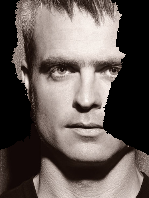

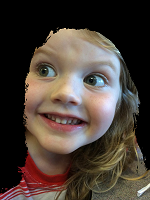

Here are two clear examples where the matting does not line up with the original image and I've removed them from the dataset.  However, the other images look really good (all things considered) and so I can safely assume that any issues with the mattings have to do with the quality of the data rather than anything being incorrect codewise.  That being said, I don't see any glaring issues outside of the hair mattings that I don't think I will be able to resolve

ARCHITECTURE

The standard architecture that has been developed in order to handle image segmentation is known as UNet.  This is a variation of the standard CNN autoencoder in that each convolved layer is both downsampled/convolved as well as passed forward to the corresponding decoding layer.

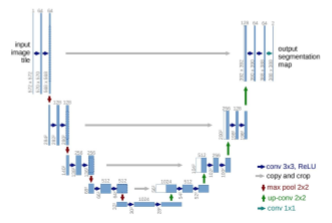

Essentially, this allows the network to learn finer details of the image while mainting global information about the image [5].  There is another possible architecture known as a Mask R-CNN.  This architecture is capable of instance segmentation, where each instance of a class is identified, not just the class itself.

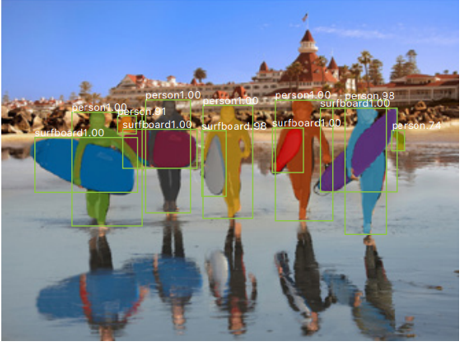

However, this is too involved for a task as 'simple' as portrait segmentation.  Even if there were multiple people, it would be completely fine to label them both as foreground.  Therefore, I will continue with UNet being the standard architecture.

In order to boost accuracy further, these neural networks rely on a fourth channel to the image.  This channel is called a trimap and resembles the finished alpha matte except it has a third region which marks uncertainty.  Things are determined as obviously foreground, obviously background, and needs further determination.  Xu et al [3] trained on a small dataset that included the 'ground truth' trimaps.  Their model takes in the color image and the trimap and returns an alpha matte, which goes through another model to refine it further.

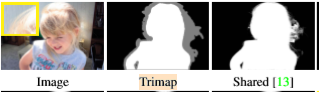

Further papers have come up with clever ways to create trimaps from the ground truth alpha mattes.  They then train a network to turn the image into an alpha matte and use both as inputs to the main neural network.  This method makes the most sense as any real application in the world will not have trimaps readily available.

I will take the majority of my inspiration for the architecture from Chen et al [6].  It consists of three stages, T-Net, M-Net, and the Fusion model.  T-Net generates the trimap from the input image.  This trimap has 3 channels, one for each class, as they found experimentally that it did not impact performance when compared to using a 1 channel trimap.  The M-Net turns the image and trimap into an alphamatte prediction.  The Fusion model then takes the alpha matte prediction as well as the foreground and uncertainty channels from the predicted trimap and generates the 'true predicted' alpha matte.

I'll go over each stage more in detail later, but this image does a great job of visualizing the process.

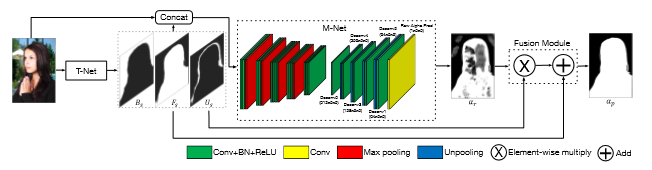

REFERENCES
1. Automatic Portrait Segmentation for Image Stylization (Xiaoyong Shen, Aaron Hertzmann, Jiaya Jia1, Sylvain Paris, Brian Price, Eli Shechtman,and Ian Sachs)
2. Boundary-Sensitive Network for Portrait Segmentation (Xianzhi Du, Xiaolong Wang, Dawei Li, Jingwen Zhu, Serafettin Tasci, Cameron Upright, Stephen Walsh, Larry Davis)
3. Deep Image Matting (Ning Xu, Brian Price, Scott Cohen, and Thomas Huang)
4. Fast Portrait Segmentation with Extremely Light-Weight Network (Yuezun Li, Ao Luo, and Siwei Lyu)
5. Image Segmentation Using Deep Learning (Shervin Minaee, Yuri Boykov, Fatih Porikli, Antonio Plaza, Nasser Kehtarnavaz, and Demetri Terzopoulos)
6. Semantic Human Matting (Quan Chen, Tiezheng Ge, Yanyu Xu, Zhiqiang Zhang, Xinxin Yang, Kun Gai)